In [1]:
""" Finding Trends of Stock Prices """
import pandas as pd 
import numpy as np 
import sqlite3 as sql 
import matplotlib.pyplot as plt
import datetime as dt 
from tqdm import tqdm 

import sys
sys.path.append('/Users/jerald/Documents/Dir/Python/Stocks')
from bin.main import Manager, get_path 
connections = get_path('../../')

In [2]:
class price_notifications(Manager):
    def __init__(self, connections = None):
        super().__init__(connections)
        self.stocks = self.Optionsdb.stocks['all_stocks']
        
    def _load_stock_prices(self, stock, daily = True,  **kwargs):
        """ Return the Closing price for all Stocks in the daily_db database """
        if daily == True: 
            out = self.Pricedb.get_indicators(stock, daily = daily, **kwargs)
        if daily == False: 
            out = self.Pricedb.get_indicators(stock, daily = daily, **kwargs)
        return out 

    def _load_indicator_and_state(self, stock, daily = True, start_date = None, end_date = None, kwargs = None):
        """ Return the Closing price for all Stocks in the daily_db database """
        if kwargs is None: kwargs = {'fast': 28,'medium': 96, 'slow': 496, 'm': 2}
        if daily == True: 
            out = self.Pricedb.get_indicators(stock, daily = daily, kwargs  = kwargs)
        if daily == False: 
            out = self.Pricedb.get_indicators(stock, daily = daily, kwargs = kwargs)
            
        states = self.Pricedb.Indicators.states
        if start_date == None: 
            start_date = out.index[0]
        if end_date == None:
            end_date = out.index[-1]
        
        out = out.loc[start_date:end_date]
        states = states.loc[start_date:end_date]
        return out, states
    
    def _is_increasing(self, series, n = 3):
        """ 
        Return a boolean if the series is increasing or not. 
        Args: 
            series: pd.Series, with a datetime index. 
            n = int, lookback/forward period to check if the series is increasing or not. 
            
        Returns:
            pd.series: Contining 1 if the series is increasing, 0 if unchanged and -1 if decreasing.
        """
        out = series.rolling(window = n).apply(lambda x: 1 if x[-1] > x[0] else -1 if x[-1] < x[0] else 0)
        return out
    
    def _plot_indicators(self, stock, daily = True, start_date = None, end_date = None, kwargs = None):
        """ Plot the indicators for the stock """
        if kwargs is None: kwargs = {'fast': 28,'medium': 96, 'slow': 496, 'm': 2, 'n': 3}
        test, states = self._load_indicator_and_state(stock, daily = daily, start_date = start_date, end_date = end_date, kwargs = kwargs)
        kama_fm_increasing = self._is_increasing(states['kama_fm'], n = kwargs['n'])

        fig, ax = plt.subplots(4,1, figsize = (10,10), gridspec_kw={'height_ratios': [2, .5, .5, .5]}, sharex=True)
        test[['close', 'kama_fast', 'kama_med']].plot(ax = ax[0]) 
        # green triangle for increasing, red for decreasing
        ax[0].scatter(test.index[kama_fm_increasing == 1], test['kama_fast'][kama_fm_increasing == 1], color = 'green', marker = '^')
        ax[0].scatter(test.index[kama_fm_increasing == -1], test['kama_fast'][kama_fm_increasing == -1], color = 'red', marker = 'v')
        

        # Fill red when kama_fast is below kama_med, green when above
        ax[0].fill_between(test.index, test['kama_fast'], test['kama_med'], where = test['kama_fast'] > test['kama_med'], color = 'green', alpha = 0.3)
        ax[0].fill_between(test.index, test['kama_fast'], test['kama_med'], where = test['kama_fast'] < test['kama_med'], color = 'red', alpha = 0.3)

        # Plot the MACD and MACD Signal
        states.loc[test.index][['macd']].plot(ax = ax[1], legend = False)
        ax[1].axhline(0, color = 'black', linestyle = '--', alpha = 0.5)
        ax[1].set_title('MACD - MACD Signal')

        # Plot the Stochastic Oscillator
        test.loc[test.index][['fast_stoch', 'slow_stoch']].plot(ax = ax[2], legend = False)
        ax[2].set_title('stochastic')
        ax[2].axhline(0.80, color = 'red', linestyle = '--', alpha = 0.5)
        ax[2].axhline(0.20, color = 'green', linestyle = '--', alpha = 0.5)

        # Plot the ATR
        states.loc[test.index][['atr']].plot(ax = ax[3], legend = False)
        ax[3].set_title('atr')
        
        plt.tight_layout()
        fig.autofmt_xdate(rotation = 0 )
        plt.show()
    
p = price_notifications('../../')

Options db Connected: 2024-11-12 15:24:47.623086
Prices Connected: 2024-11-12 15:24:47.623839





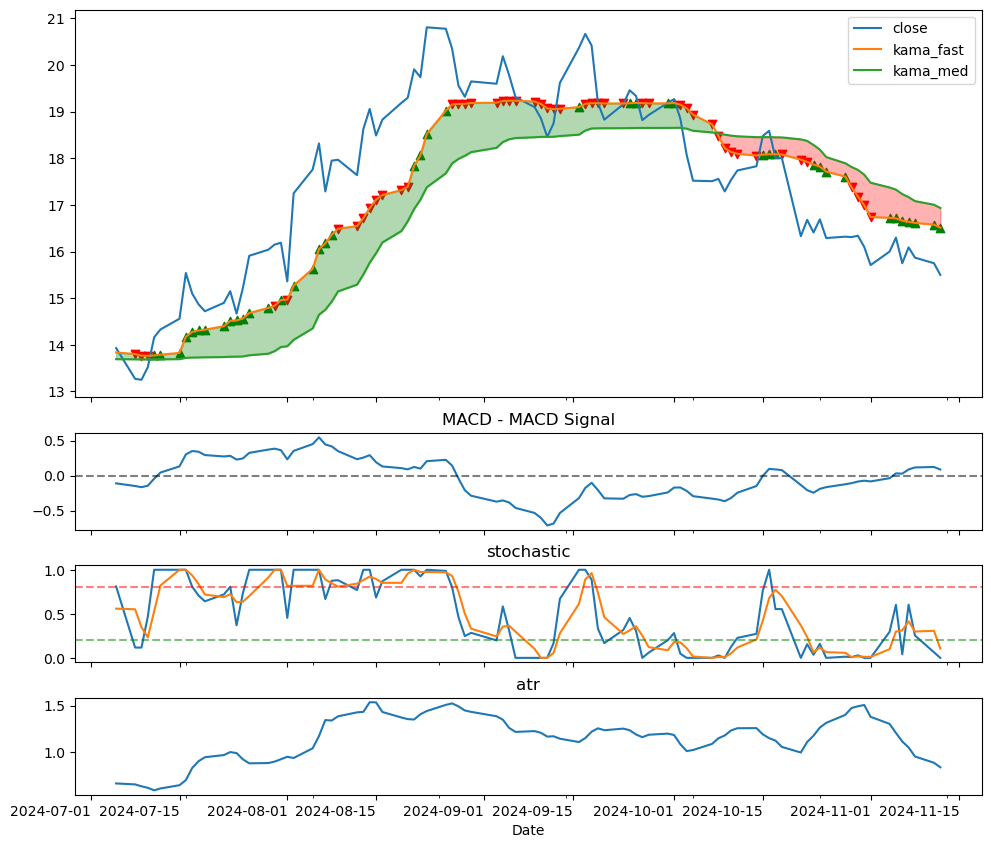

In [3]:
kwargs = {'fast': 10,'medium': 28, 'slow': 96, 'm': 2 , 'n': 2}
df, state = p._load_indicator_and_state('wmt', start_date="2024-05-04", kwargs = kwargs)
p._plot_indicators('rkt', start_date="2024-07-04", kwargs = kwargs)

In [10]:
all_stocks = p.Pricedb.all_stock_Close()
# kwargs = {'fast': 28,'medium': 96, 'slow': 496, 'm': 2}
kwargs = None

d = {}
for stock in list(all_stocks.columns):
    df, states = p._load_indicator_and_state(stock, daily = True, kwargs = kwargs)
    d[stock] = {'indicators': df, 'states': states}
    

In [12]:
# Stocks with price about to cross above the fast ema 
stocks_crossing_above_fast_ema = []
for stock in list(all_stocks.columns):
    above_ema = all_stocks[stock].iloc[-1] > d[stock]['indicators']['ema_fast'].iloc[-1]
    increasing = all_stocks[stock].iloc[-2] < d[stock]['indicators']['ema_fast'].iloc[-2]
    if above_ema and increasing: 
        stocks_crossing_above_fast_ema.append(stock)

print("Stocks with price about to cross above the fast ema: ", stocks_crossing_above_fast_ema)
# Stocks with MACD about to cross above the macd_signal 
stocks_crossing_above_macd_signal = []
for stock in list(all_stocks.columns):
    avg_change = d[stock]['states']['macd'].abs().mean()
    above_macd = d[stock]['states']['macd'].iloc[-1] > 0
    increasing = d[stock]['states']['macd'].iloc[-2] < avg_change
    if above_macd and increasing: 
        stocks_crossing_above_macd_signal.append(stock)
        
print("Stocks with MACD about to cross above the macd_signal: ", stocks_crossing_above_macd_signal)


# Stocks with kama_fast about to cross kama_med 

stocks_crossing_above_kama_fast = []
for stock in list(all_stocks.columns):
    above_kama = all_stocks[stock].iloc[-1] > d[stock]['indicators']['kama_fast'].iloc[-1]
    increasing = all_stocks[stock].iloc[-2] < d[stock]['indicators']['kama_fast'].iloc[-2]
    kama_above_med = d[stock]['indicators']['kama_fast'].iloc[-1] > d[stock]['indicators']['kama_med'].iloc[-1]
    if above_kama and increasing and kama_above_med: 
        stocks_crossing_above_kama_fast.append(stock)

print("Stocks with with price about to cross kama_fast and kama_fast above kama medium: ", stocks_crossing_above_kama_fast)


Stocks with price about to cross above the fast ema:  ['crwd', 'mrk', 'sono']
Stocks with MACD about to cross above the macd_signal:  ['gdx', 'xlf', 'aal', 'igv', 'uber', 'xli', 'ups', 'sq', 'vxx', 'fcel', 'vale', 'rrc', 'fdn', 'jks', 'vuzi', 'lmt', 'mrk', 'baba', 'slv', 'sol', 'ardx', 'msft', 'moo', 'rblx', 'iei', 'ief', 'sono', 'pypl', 'amd', 'xlb', 'xlv', 'lqd', 'tlt', 'wba', 'ung', 'ge', 'intu', 'ctva', 'corn', 'aa', 'csco', 'cvs', 'chgg', 'ko', 'icln', 'li', 'roku', 'lcid', 'weat', 'abnb', 'sony', 'hood', 'uvxy', 'afl', 'sofi', 'dia', 'ttd', 'dash', 'open', 'dbx', 'tdoc', 'expe', 'dell']
Stocks with with price about to cross kama_fast and kama_fast above kama medium:  ['jpm']


In [13]:

# Stocks with price about to cross above the fast ema:  ['xlf', 'xlc', 'intu', 'fang', 'itb', 'jpm', 'ttd', 'panw', 'expe']
# Stocks with MACD about to cross above the macd_signal:  
# ['uber', 'mdb', 'pltr', 'vxx', 'mo', 'lc', 'baba', 'ardx', 'meta', 'ebay', 'pypl', 'xlp', 'xom', 'xlv', 'lqd', 'wba', 'chgg', 'li', 'run', 'x', 'spot', 'cag', 'uvxy', 'pgr']



stock = 'wmt'
start = '2024-01-01'
kwargs = {'fast': 10,'medium': 20, 'slow': 96, 'm': 2}